In [140]:
import chainer
import pyaml
import numpy as np
import sys

sys.path.append("..")
chainer.config.cv_resize_backend = "cv2"


from dataclasses import dataclass
from pathlib import Path
from matplotlib import pyplot as plt
from chainercv import transforms as tr
from chainercv.visualizations import vis_bbox
from chainer.backends.cuda import to_cpu
from chainer.backends.cuda import get_device_from_id
from functools import partial
from functools import reduce

from cvdatasets import FolderAnnotations
from cvdatasets import FileListAnnotations
from cvdatasets.dataset.image import Size

from moth_detector.core import models


In [141]:
@dataclass
class Args(object):
    def __str__(self):
        return pyaml.dump(dict(Arguments=self.__dict__))
    
    data_root:             Path = Path.home() / "Data" / "DATASETS" / "moths" / "AMMOD"
    
    
    input_size:            int  = 300
    weights:               str  = "imagenet"
    gpu:                   int  = 0
        
MEAN = np.array((123, 117, 104), dtype=np.float32).reshape((-1, 1, 1))

weights = list(Path("../.results/ssd/AMMOD_MOTHS/rmsprop/").glob("*/clf_final.npz"))
args = Args(weights=weights[0])
print(args)

Arguments:
  data_root: /home/korsch/Data/DATASETS/moths/AMMOD
  gpu: 0
  input_size: 300
  weights: ../.results/ssd/AMMOD_MOTHS/rmsprop/2021-03-15-19.31.43.615474277/clf_final.npz



In [142]:
!ls /home/korsch/Data/DATASETS/moths/AMMOD/BREHM2/

images	images.txt  labels.txt	tr_ID.txt


In [143]:
def preprocess(im, transforms):
    global MEAN
    X = im.transpose(2, 0, 1)
    
    for func in transforms:
        X = func(X)
    
    return X - MEAN

def init_data(args: Args):
    annot = FolderAnnotations(root_or_infofile=args.data_root / "MCC_raw", 
                              folders=dict(
                                  train_images="train", 
                                  val_images="val", 
                                  test_images=("null", True))
                             )
    
    #annot = FileListAnnotations(root_or_infofile=args.data_root / "BREHM2")

    ds = annot.new_dataset()
    
    size = Size(args.input_size)
    
    transforms = [
#         partial(tr.scale, size=min(size), fit_short=True),
#         partial(tr.center_crop, size=tuple(size)),
        
        partial(tr.resize, size=tuple(size)),
    ]
    
    print(f"Loaded {len(ds)} images from {annot.root}")
    return ds, transforms

In [144]:
def init_model(args: Args):
    pretrained, load = None, args.weights
    
    if args.weights in models.SSD_Model._models:
        print(f"Loading default weights \"{load}\"...")
        pretrained, load = load, pretrained
        
    model = models.SSD_Model(
        pretrained_model=pretrained,
        input_size=args.input_size, 
        n_fg_class=1,
    )
    if load is not None:
        print(f"Loading weights from \"{load}\"...")
        model.load_for_inference(load, n_classes=1, path="model/")
    
    device = get_device_from_id(args.gpu)
    device.use()
    
    model.to_device(device)
    
    return model


Loaded 55 images from /home/korsch/Data/DATASETS/moths/AMMOD/MCC_raw
Loading weights from "../.results/ssd/AMMOD_MOTHS/rmsprop/2021-03-15-19.31.43.615474277/clf_final.npz"...


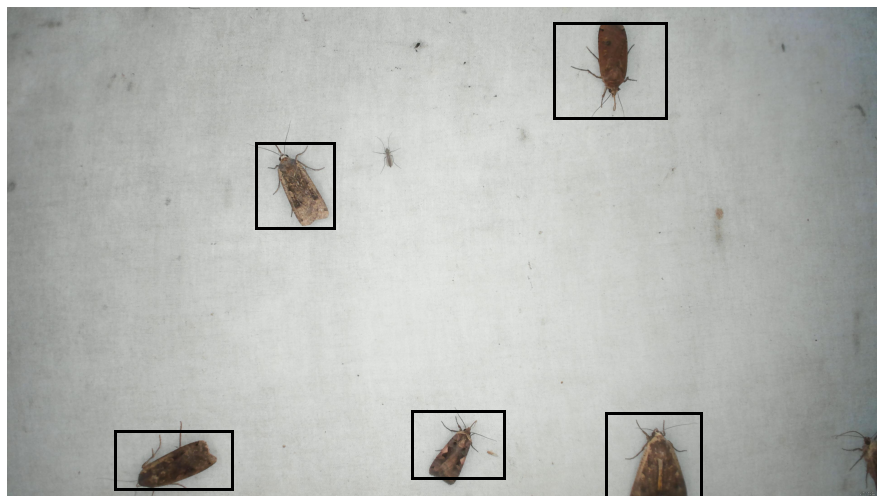

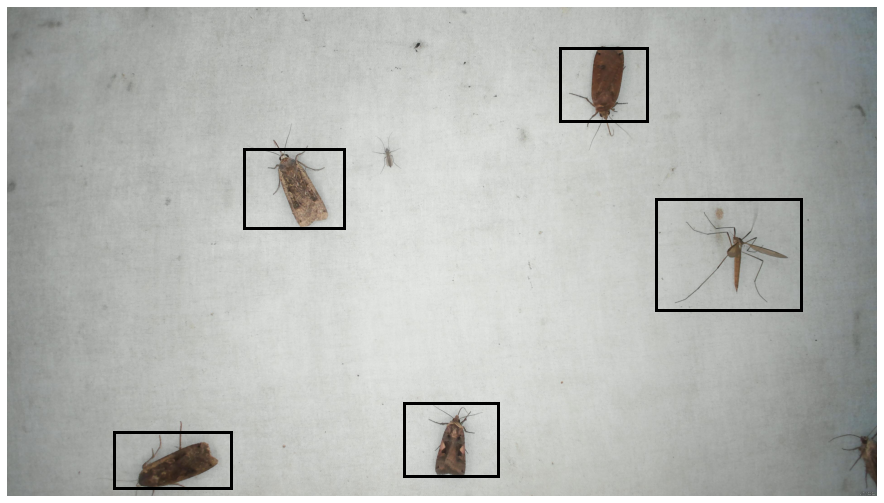

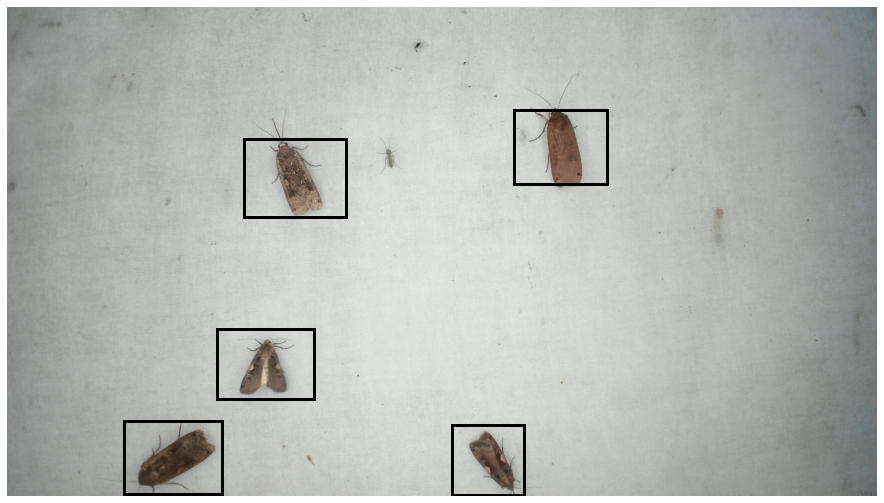

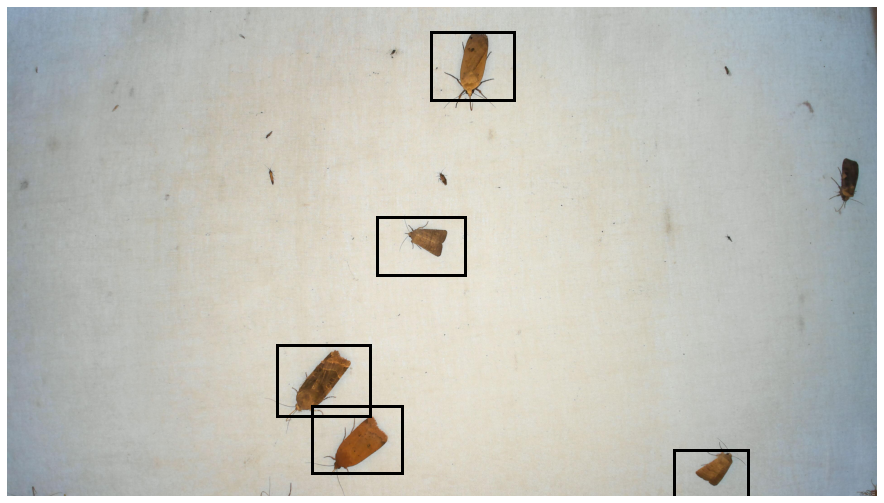

In [174]:
def main(args: Args):
    ds, transforms = init_data(args)
    model = init_model(args)

    model.nms_thresh = 0.1
    model.score_thresh = 0.01
    
    idxs = [7, 1, 25, 34]

    for i, (orig, _, y) in enumerate(ds[idxs]):
        X = preprocess(orig, transforms)
        boxes, labels, scores = model.predict([X])
        box, label, score = map(to_cpu, [boxes[0], labels[0], scores[0]])
        
        topk = np.argsort(-score)[:50]
        box = box[topk]
        
        box = tr.resize_bbox(box, X.shape[1:], orig.shape[:-1])
        
        fig, ax = plt.subplots(figsize=(16,9))
        ax.axis("off")
        #ax.set_title(f"Idx: {i}")
        
        vis_bbox(orig.transpose(2, 0, 1), box, 
                 ax=ax, 
#                  alpha=0.7,
                 instance_colors=[(0,0,0)])
        
        plt.show()
        plt.close()
        
    
with chainer.using_config("train", False), chainer.no_backprop_mode():
    main(args)